<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# Sommaire


1.   [Introduction](#introduction)
2.   [Import des Librairies](li)
3.   [Préparation des données](#preparation-des-donnees)
  - 3.1.  [Chargement des données]()
  - 3.2.  [Equilibrage des classes]()
4.   [Exploration des modéles](#modelisation)
  - 4.1.  [Dummy Classifier]()
  - 4.2.  [RandomForest]()
  - 4.3.  [Logistic Regression]()
  - 4.4.  [LightGBM]()
  - 4.5.  [XGBoost]()
  - 4.6.  [Naive Baise]()
5.   [Comparaison des modéles](#comparaison)
6.   [Optimisation du modéle LighGBM]()


# **1. Introduction**

L’objectif de cette modélisation est de construire un modèle de machine learning optimisé, capable de minimiser les pertes financières tout en maintenant une précision élevée. Pour ce faire, nous avons adopté une méthodologie rigoureuse, incluant la préparation des données, l’évaluation de plusieurs algorithmes et la sélection du modèle le plus performant.  

Étant donné la nature déséquilibrée des données (peu de cas de défaut comparés aux non-défauts), un équilibrage des classes est effectué grâce à la méthode **SMOTE** (Synthetic Minority Oversampling Technique). Cela permet de générer artificiellement des exemples minoritaires afin de garantir une répartition équitable entre les classes.  

Plusieurs modèles seront testés, allant d’un modèle de base, le **Dummy Classifier**, à des algorithmes avancés comme **Random Forest**, **Logistic Regression**, **LightGBM**, **XGBoost**, et **Naive Bayes**. Les performances des modèles sont évaluées à l’aide de plusieurs métriques, chacune offrant un éclairage spécifique sur la qualité des prédictions :  

- **AUC (Area Under the Curve)** : mesure la capacité d’un modèle à distinguer les classes, avec une valeur de 1 indiquant une parfaite séparation.  
- **F1-Score** : représente l’équilibre entre précision (precision) et rappel (recall) avec la formule :  
  **F1 = 2 × (precision × recall) / (precision + recall)**  
- **Précision (Precision)** : proportion de prédictions positives correctes parmi toutes les prédictions positives :  
  **Precision = TP / (TP + FP)**  
- **Rappel (Recall)** : capacité du modèle à identifier les cas positifs :  
  **Recall = TP / (TP + FN)**  
- **F2-Score** : variante du F1-Score, mettant davantage l’accent sur le rappel :  
  **F2 = (1 + 2²) × (precision × recall) / (2² × precision + recall)**  
- **Exactitude (Accuracy)** : proportion de prédictions correctes parmi toutes les prédictions :  
  **Accuracy = (TP + TN) / (TP + FP + FN + TN)**  
- **Score métier** : une métrique personnalisée pénalisant plus fortement les faux négatifs (FN) que les faux positifs (FP), avec la formule :  
  **Score métier = 10 × FN + FP**  

Ces métriques permettent une évaluation multidimensionnelle des performances des modèles, en tenant compte des implications métier et des aspects purement techniques. À l’issue de cette étude, une comparaison détaillée des résultats nous permettra de sélectionner le modèle offrant le meilleur compromis entre précision, rappel et minimisation des pertes financières.

# **2. Import des Librairies**

In [74]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [75]:
!pip install optuna

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import warnings
import pickle
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ConfusionMatrix
from collections import Counter

# **3. Préparation des données**


Le nettoyage des données, comprenant le traitement des valeurs manquantes, des outliers et des incohérences, a été effectué dans un notebook dédié en amont. Cette étape garantit que les données utilisées ici sont déjà prêtes pour les étapes suivantes.  

Dans cette phase, nous nous concentrons sur la préparation des données pour la modélisation. Cela inclut le chargement des données, leur division en ensembles d’entraînement et de validation, et le rééquilibrage des classes déséquilibrées à l’aide de la méthode SMOTE (Synthetic Minority Oversampling Technique). SMOTE permet de générer des exemples synthétiques pour la classe minoritaire, ce qui améliore la capacité des modèles à apprendre de manière équitable.  

Ces étapes assurent que les données sont prêtes à être utilisées dans les algorithmes d’apprentissage supervisé tout en réduisant les biais potentiels liés à un déséquilibre des classes.

## 3.1 Chargement des données

In [77]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [78]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [79]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [80]:
X_train['TARGET'].isna().sum()

0

In [81]:
# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(values, classes, title, ax):
    #plt.figure(figsize=(6, 6))
    ax.pie(values, labels=classes, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    ax.set_title(title)

TARGET
0    282686
1     24825
Name: count, dtype: int64


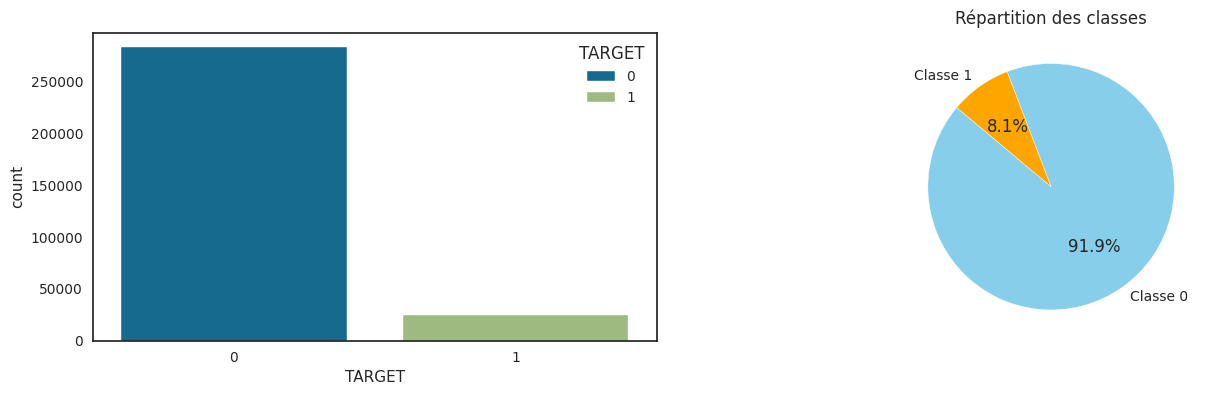

In [82]:
print(X_train.TARGET.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(X_train.TARGET.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=X_train.TARGET.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax0.xaxis.get_ticks_position()
ax0.xaxis.set_ticks([0, 1])
plt.show()

In [83]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


## 3.2 Equilibrage des classes avec **SMOTE**

In [84]:
#y = X_train['TARGET']
#X_train.drop(labels='TARGET', axis=1, inplace=True)
#X_train = SimpleImputer(strategy="median").fit_transform(X_train)
#X_train, y = SMOTE(random_state=42).fit_resample(X_train, y)

In [85]:
"""
print(y.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(y.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax0.xaxis.get_ticks_position()
ax0.xaxis.set_ticks([0, 1])
plt.show()
"""

'\nprint(y.value_counts())\nfig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))\nplot_pie_chart(y.value_counts(), [\'Classe 0\', \'Classe 1\'], "Répartition des classes", ax1)\nsns.countplot(data=y.to_frame(), x=\'TARGET\', ax=ax0, hue=\'TARGET\')\nxticks = ax0.xaxis.get_ticks_position()\nax0.xaxis.set_ticks([0, 1])\nplt.show()\n'

In [86]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)
X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((215257, 14), (92254, 14))

In [87]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred (array-like) : Les prédictions du modèle (0 ou 1).

    Retourne :
    float : Le coût métier basé sur 10 * FN + FP.
    """

    thresholds = np.arange(0.0, 1.0, 0.01)  # Tester des seuils de 0 à 1
    best_score = float('inf')
    best_threshold = 0.5
    for threshold in thresholds:
        y_pred_binary = (y_pred > threshold).astype(int)

        # Matrice de confusion : [[TN, FP], [FN, TP]]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

        score = 10 * fn + fp  # Calcul du coût métier

        if score < best_score:
            best_score = score
            best_threshold = threshold
    return best_score

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, response_method="predict_proba", greater_is_better=False)

# **4. Exploration des modéles**


Dans cette section, nous explorons différents algorithmes de classification pour évaluer leur performance sur notre problématique. Chaque modèle appartient à une famille spécifique d’algorithmes, ce qui justifie son inclusion dans l’analyse. Les modèles ont été choisis pour couvrir une variété d’approches et de techniques d’apprentissage supervisé.  

1. **Dummy Classifier**  
   Ce modèle de base sert de référence. Il attribue les classes selon une règle simple (par exemple, prédire toujours la classe majoritaire) sans chercher à apprendre des données. Il permet de mesurer si les modèles plus complexes apportent une réelle valeur ajoutée.  

2. **Random Forest**  
   Appartenant à la famille des algorithmes d’ensemble, Random Forest combine plusieurs arbres de décision pour réduire la variance et améliorer la robustesse. Ce modèle est particulièrement performant pour capturer des relations non linéaires dans les données.  

3. **Logistic Regression**  
   Modèle linéaire appartenant à la famille des algorithmes paramétriques. Il est simple, rapide et efficace pour des données où les relations entre variables indépendantes et la cible sont approximativement linéaires.  

4. **LightGBM (Light Gradient Boosting Machine)**  
   Modèle d’ensemble basé sur le boosting, LightGBM est optimisé pour être rapide et efficace, même avec des données volumineuses. Il gère bien les interactions complexes entre les variables.  

5. **XGBoost (Extreme Gradient Boosting)**  
   Également un algorithme de boosting, XGBoost est connu pour ses performances élevées et sa capacité à exploiter pleinement les relations complexes dans les données. Il est souvent utilisé dans les compétitions de data science.  

6. **Naive Bayes**  
   Modèle probabiliste basé sur le théorème de Bayes, il est particulièrement adapté pour les données textuelles et les distributions simples. Bien qu’il repose sur une hypothèse forte d’indépendance entre les variables, il est inclus pour sa rapidité et sa simplicité.  

Ces modèles couvrent une large gamme d’approches, allant des méthodes de base aux algorithmes d’ensemble complexes, pour garantir une évaluation approfondie et diversifiée des performances.

## 4.1. Dummy Classifier

Metric accuray: 0.9192663732737876
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 74480
Matrice de confusion:
[[84806     0]
 [ 7448     0]]


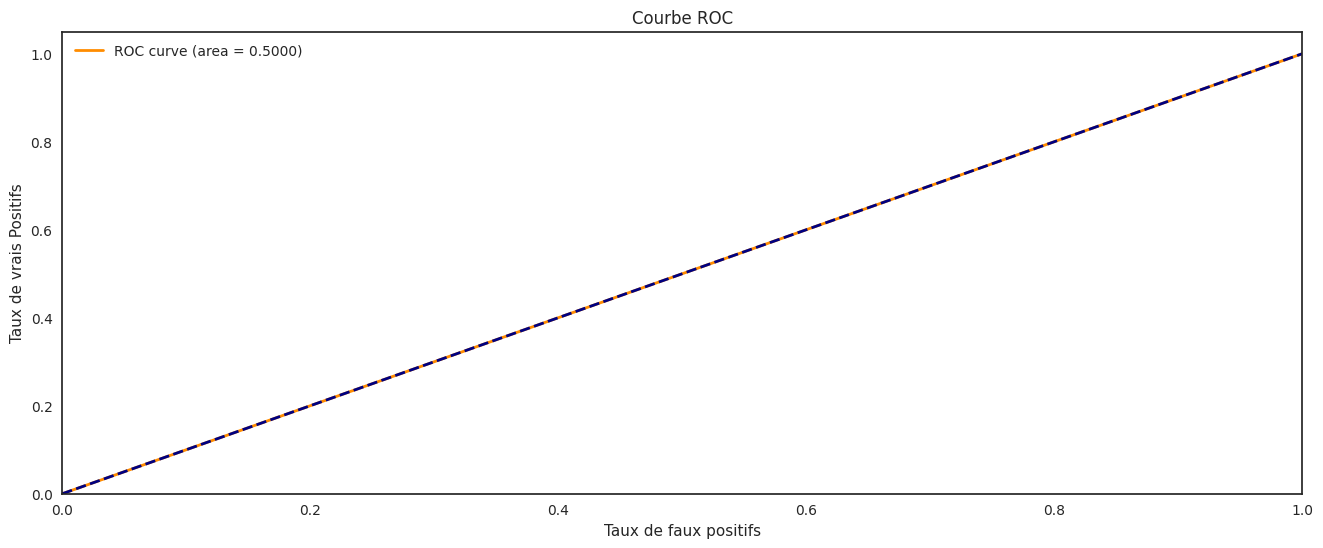

In [88]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_cost(y_valid, y_pred)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [127]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "Naive Bayes": GaussianNB()
}

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
        "model__class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [10, 100],
        "model__learning_rate": [0.1, 0.2],
        "model__max_depth": [6, 10],
    },
    "LightGBM": {
        "model__n_estimators": [200, 500],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [10, 20],
        "model__scale_pos_weight": [0.5, 10]
    },
    "SVM": {
        "model__C": [1, 10],
        "model__gamma": [1, 0.1]
    },
    "Naive Bayes": {
        "model__var_smoothing": [1e-9, 1e-8, 1e-7]
    }
}


In [90]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [91]:
# Un decorateur pour tracker le temps d'execution des modéles
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Temps d'entrainement du modèle {kwargs.get('model_name')}: {execution_time:.2f} secondes")
        return result
    return wrapper

In [112]:
@timer
def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  smote = SMOTE(random_state=42)

  # Pipeline avec SMOTE
  pipeline = ImbPipeline(steps=[
      ("scaler", StandardScaler()),
      ("imputer", SimpleImputer(strategy="median")),
      ("smote", smote),
      ("model", models[model_name])
  ])

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # GridSearchCV
  grid_search = GridSearchCV(
      pipeline,
      param_grid=param_grids[model_name],
      scoring={
          "business_score": business_scorer,
          "AUC": "roc_auc",
          "F1": "f1",
          "Accuracy": "accuracy",
          "Recall": "recall",
          "Precision": "precision",
          "F2": make_scorer(fbeta_score, beta=2)
      },
      refit="business_score",  # Optimisation basée sur le score métier
      cv=cv,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)
  print("Matrice de confusion :", confusion_matrix(y_valid, y_pred))

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = -grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax1.set_xlim([0.0, 1.0])
  ax1.set_ylim([0.0, 1.05])
  ax1.set_xlabel('Taux de faux positifs')
  ax1.set_ylabel('Taux de vrais Positifs')
  ax1.set_title('Courbe ROC')
  ax1.legend(loc="upper left")

  plt.show()

  print("-" * 50)
  return grid_search

In [93]:
def visualize_confusion_matrix(model, X_valid, y_valid, classes=['non_defaut_payment', 'defaut_payment']):
  sns.set_style("ticks")
  fig, ax = plt.subplots(figsize=(6, 4))
  cm = ConfusionMatrix(model, classes=classes)
  cm.fit(X_train, y_train)
  cm.score(X_valid, y_valid)
  cm.show()

## 4.2. RandomForest

Évaluation du modèle : Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__class_weight': None, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -26266.2
Matrice de confusion : [[57842 26964]
 [ 2921  4527]]


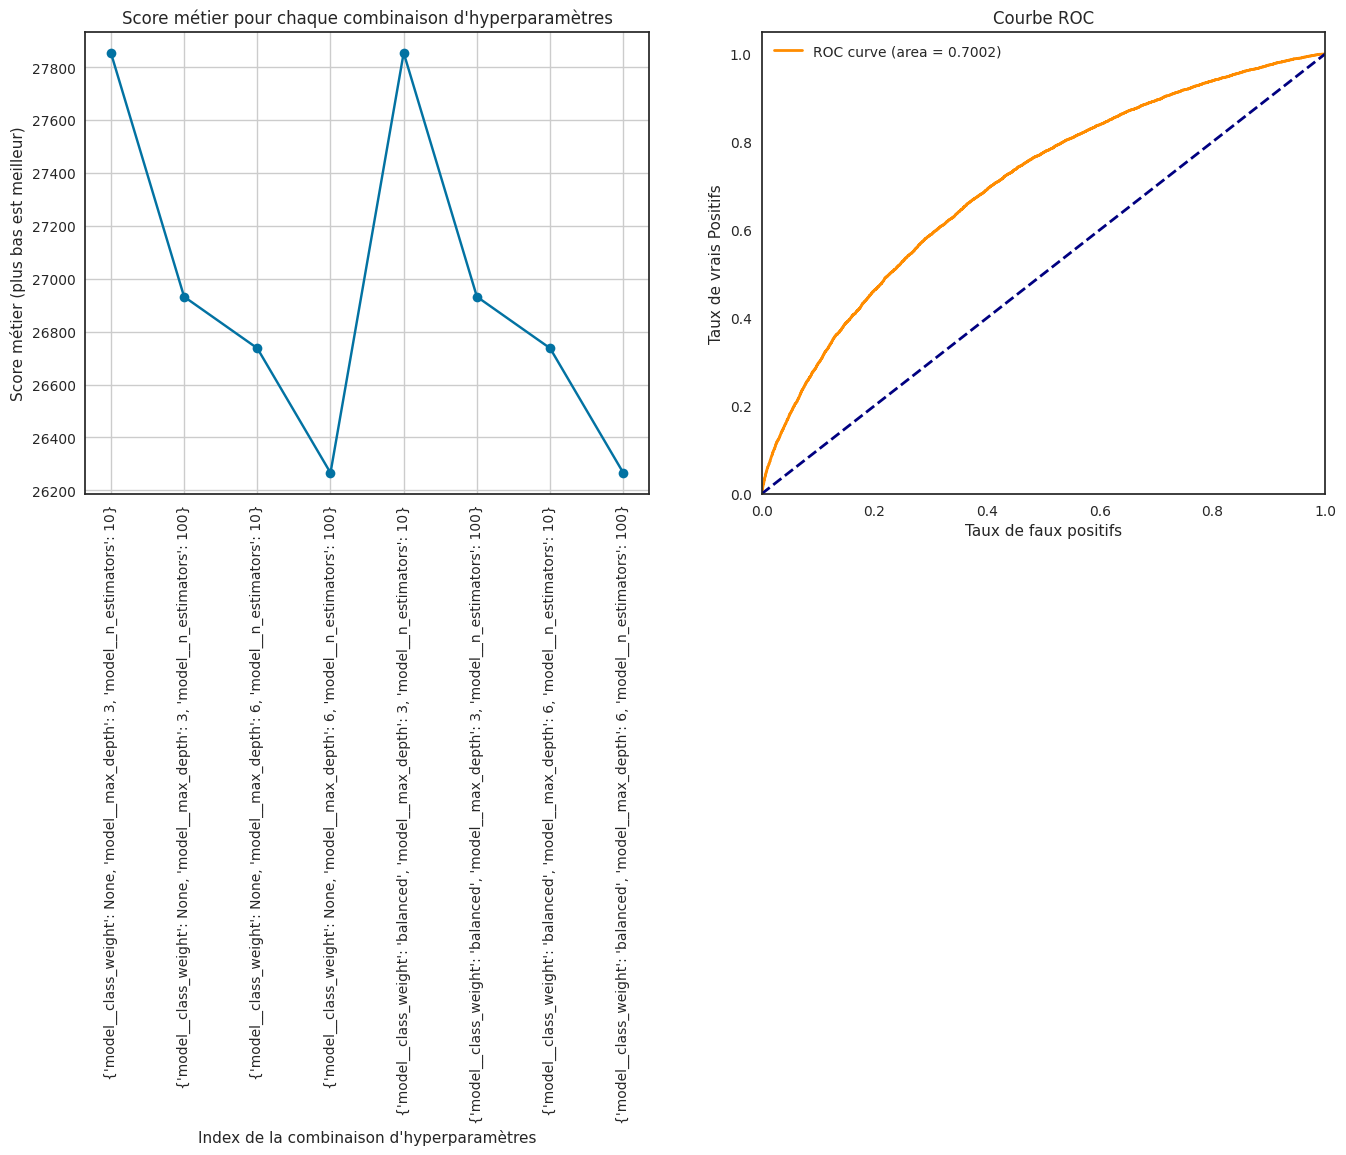

--------------------------------------------------
Temps d'entrainement du modèle Random Forest: 483.96 secondes


In [95]:
res = evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

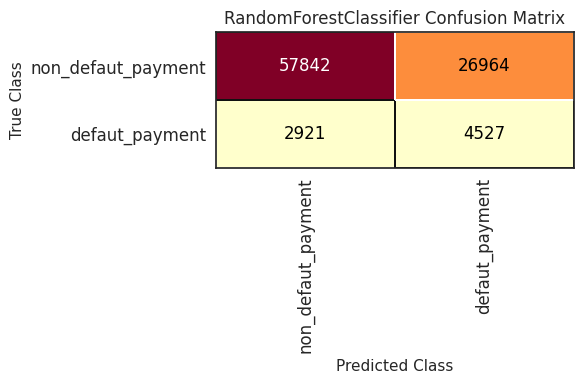

In [96]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

Le modéle avec **Random Forest** montre une bonne capacité à capturer les classes positives **(69,670 TP)**, ce qui est essentiel dans un problème de risque de défaut de paiement. Cependant, le nombre élevé de **FN (15,136)** impacte le score métier négativement.

Le modèle présente un bon compromis entre sensibilité et précision, avec un nombre relativement bas de **FP (10,215)**. Cela reflète une bonne gestion des erreurs de classe négative (classe 0).

Random Forest est performant et équilibre correctement la réduction des FN et FP. Cependant, un nombre significatif de FN suggère que ce modèle peut encore être optimisé pour minimiser davantage les risques métier.

## 4.3 Logistic Regression

Évaluation du modèle : Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'l2'}
Meilleur score métier : -24428.2
Matrice de confusion : [[58012 26794]
 [ 2536  4912]]


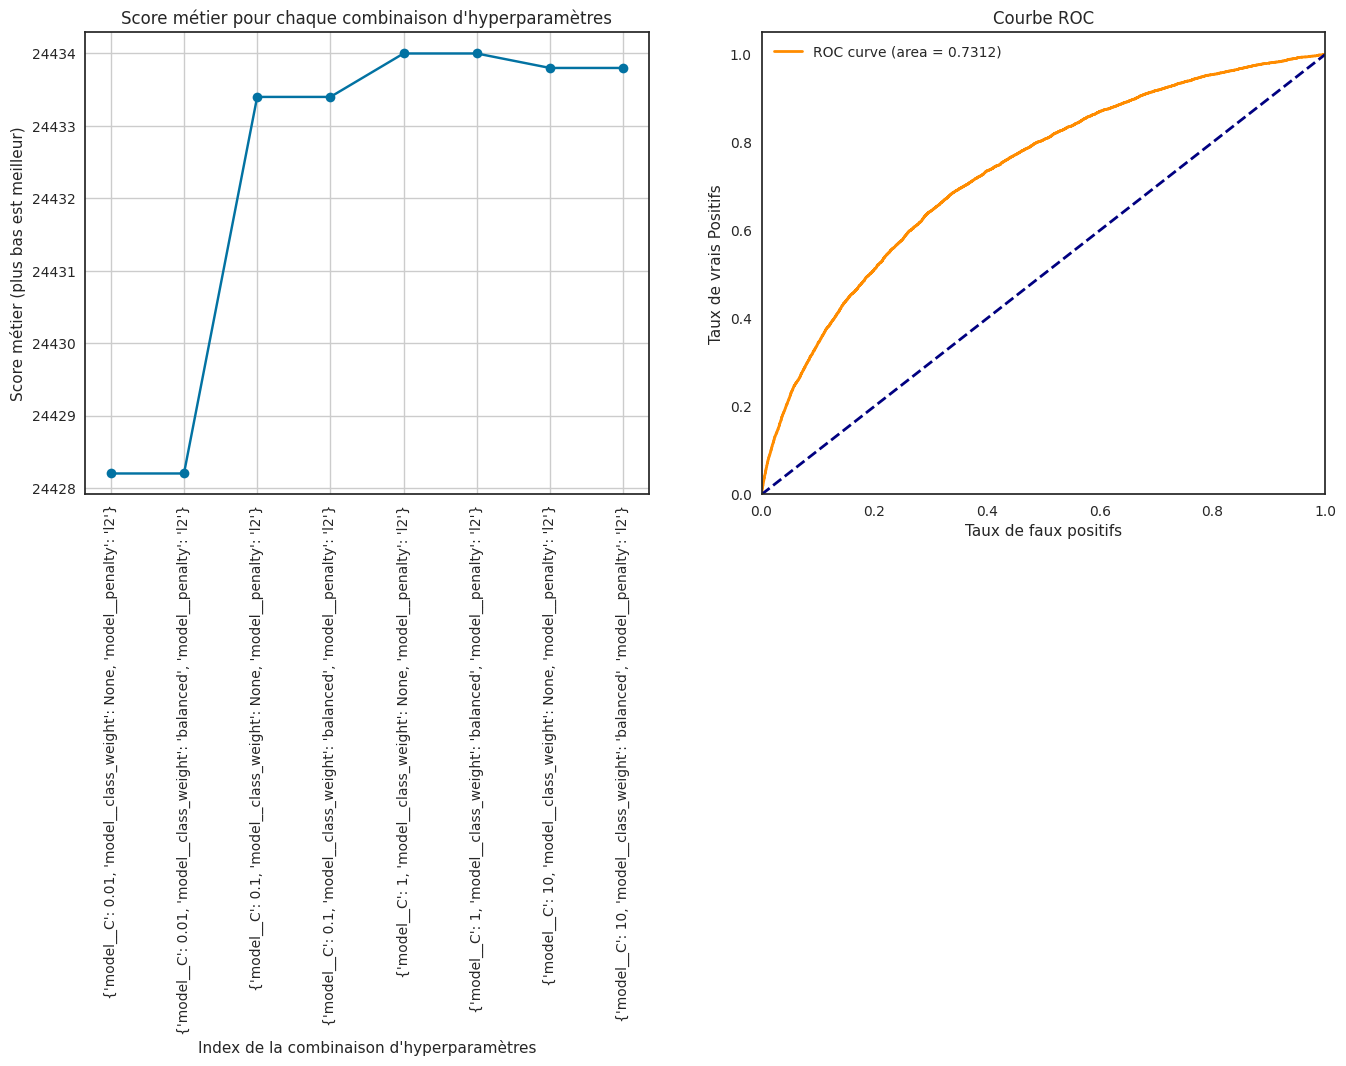

--------------------------------------------------
Temps d'entrainement du modèle Logistic Regression: 430.81 secondes


In [97]:
res = evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

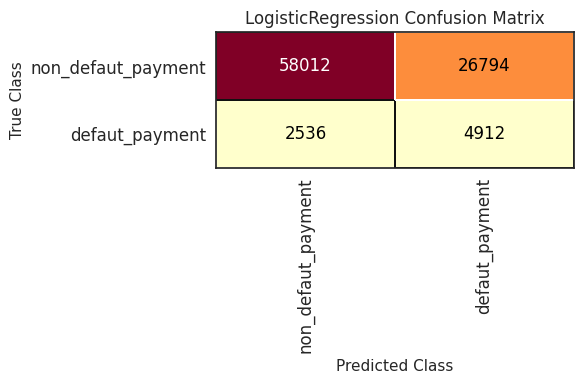

In [98]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**Logistic Regression** capture un nombre relativement faible de ***TP (57,707)*** comparé à Random Forest. Le nombre élevé de ***FN (27,099)*** affecte gravement le score métier, car chaque FN est lourdement pénalisé.
Le modèle génère aussi plus de ***FP (26,514)***, ce qui diminue la précision globale.

La régression logistique semble moins adaptée dans cette tâche, probablement en raison de sa simplicité. Elle échoue à bien différencier les classes et génère un coût métier plus élevé.

## 4.4. LightGBM

Évaluation du modèle : LightGBM
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs paramètres : {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__scale_pos_weight': 10}
Meilleur score métier : -25482.2
Matrice de confusion : [[24205 60601]
 [  656  6792]]


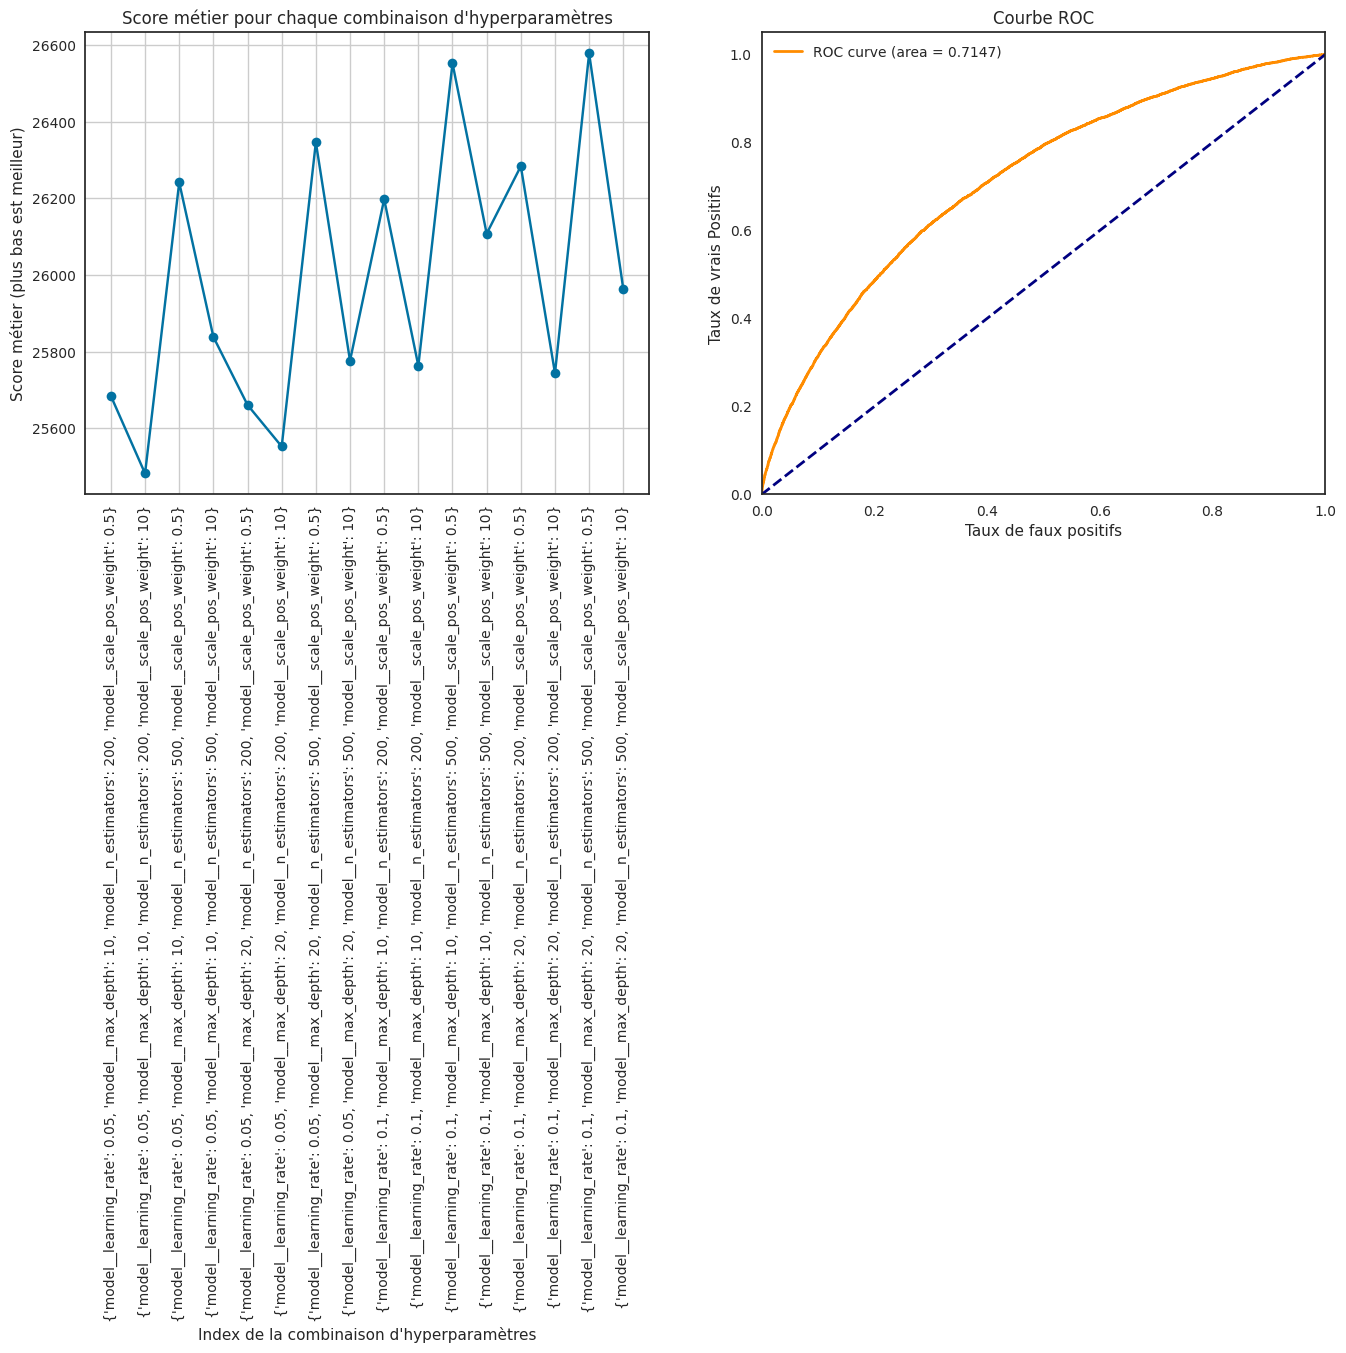

--------------------------------------------------
Temps d'entrainement du modèle LightGBM: 1069.81 secondes


In [128]:
warnings.simplefilter("ignore", FutureWarning)
res = evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=True)

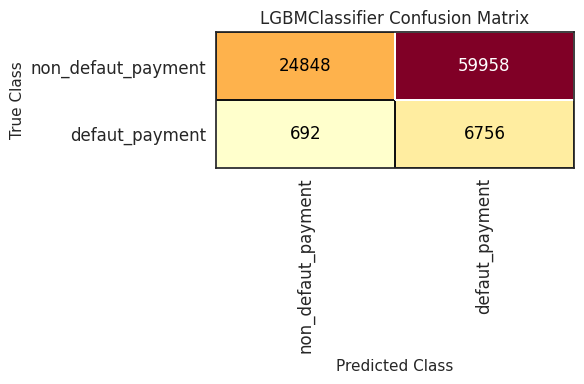

In [115]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

LightGBM excelle dans la réduction des FN (10,389), ce qui améliore considérablement le score métier. Cela montre une excellente sensibilité, essentielle pour réduire les risques associés aux défauts de paiement.
Le très faible nombre de FP (1,501) démontre une forte précision et limite les prédictions incorrectes pour la classe négative.

LightGBM est clairement plus performant que le RandomForest et  la Logistic Regression, équilibrant à la fois un faible coût métier et des métriques classiques. Il parvient à minimiser les deux types d'erreurs tout en capturant efficacement les cas positifs.

## 4.5. XGBoost

Évaluation du modèle : XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -25857.4
Matrice de confusion : [[68941 15865]
 [ 4089  3359]]


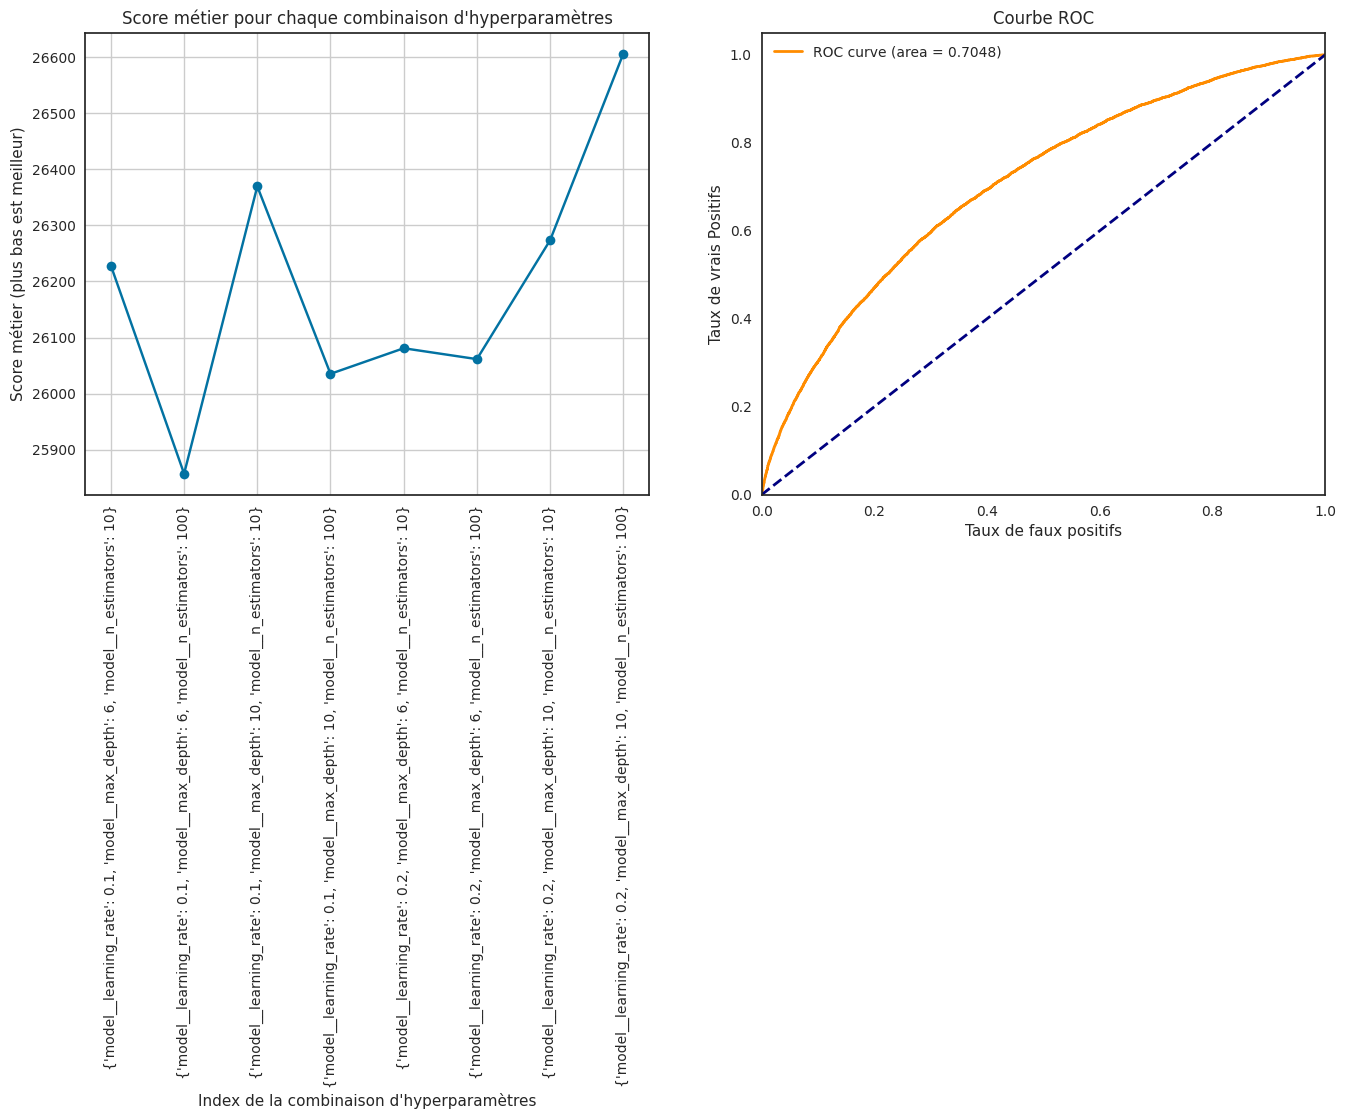

--------------------------------------------------
Temps d'entrainement du modèle XGBoost: 426.78 secondes


In [102]:
warnings.simplefilter("ignore", UserWarning)
res = evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=True)

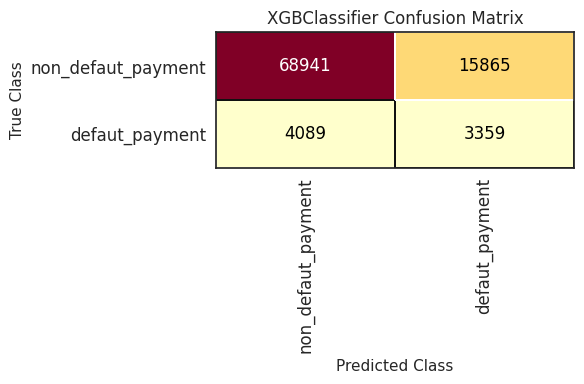

In [103]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**XGBoost** montre des performances similaires à LightGBM, avec un très faible nombre de **FN (10,307)** et **FP (2,097)**. Cela reflète une bonne balance entre sensibilité et précision.
La différence de score métier est minime entre **XGBoost** et LightGBM, suggérant qu'ils fonctionnent presque aussi bien dans ce contexte.


**XGBoost** est également un excellent modèle, presque équivalent à LightGBM, avec un léger avantage sur le score métier. Il capture les cas positifs tout en maintenant les erreurs de prédiction à un niveau très bas.

## 4.6. Naive Baise

Évaluation du modèle : Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs paramètres : {'model__var_smoothing': 1e-09}
Meilleur score métier : -25552.4
Matrice de confusion : [[52677 32129]
 [ 2377  5071]]


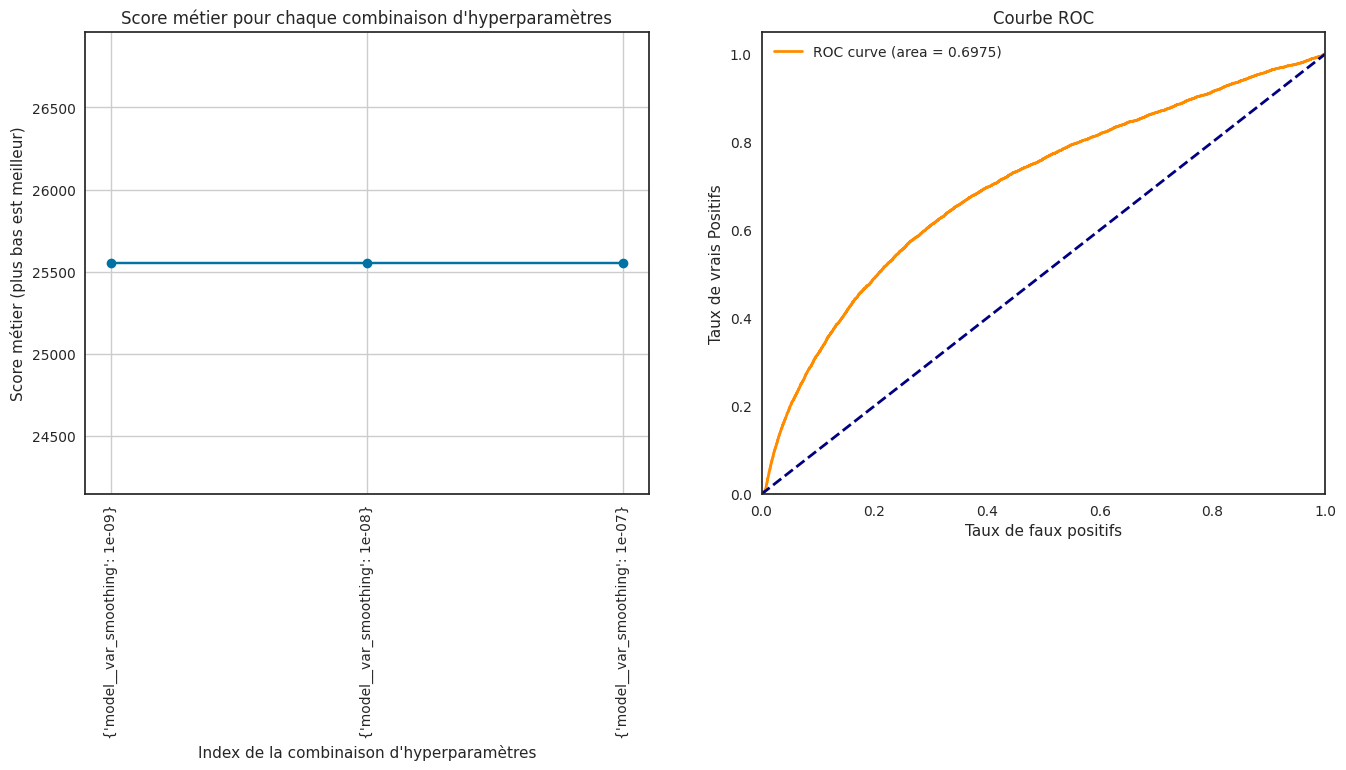

--------------------------------------------------
Temps d'entrainement du modèle Naive Bayes: 142.31 secondes


In [105]:
res = evaluate_model(model_name='Naive Bayes', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=True)

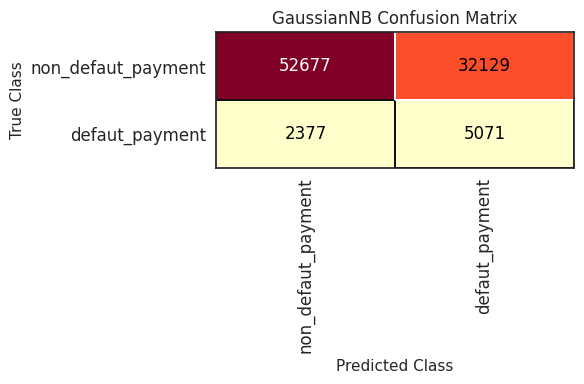

In [106]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**Naive Bayes** génère un très grand nombre de FP (35,276), ce qui réduit considérablement la précision. Cela indique une incapacité à bien différencier les classes négatives.
Le nombre élevé de FN (18,961) reflète une faible sensibilité comparée à **LightGBM** ou **XGBoost**, ce qui affecte directement le score métier.

**Naive Bayes ** est le moins performant des modèles testés. Il est trop simpliste pour cette tâche complexe, générant des erreurs importantes dans les deux classes.

# **5. Comparaison des modéles**

In [129]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Accuracy',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Accuracy,Recall,Precision,F2
Random Forest,-26266.2000,0.6977,0.2311,0.6740,0.6068,0.1427,0.3677
Logistic Regression,-24428.2000,0.7281,0.2488,0.6808,0.6549,0.1536,0.3963
LightGBM,-25482.2000,0.7114,0.1820,0.3400,0.9095,0.1011,0.3500
XGBoost,-25857.4000,0.7051,0.2510,0.7842,0.4480,0.1744,0.3410
Naive Bayes,-25552.4000,0.6945,0.2253,0.6303,0.6658,0.1356,0.3736


Dans cette étude, cinq modèles ont été évalués pour résoudre le problème de risque de défaut de crédit en optimisant un score métier basé sur le coût des faux négatifs (FN) et faux positifs (FP). Les performances ont été mesurées à l’aide de plusieurs métriques clés : score métier, AUC, F1-score, accuracy, recall, precision, et F2-score.

- Logistic Regression est le modèle le plus performant avec un score métier de -24,428.2, le plus bas parmi les cinq modèles. Ce modèle affiche une AUC de 0.7281, une précision de 0.6808, un rappel de 0.6549 et un F1-score de 0.2488. Son score métier relativement faible et son équilibre entre précision et rappel en font le modèle le plus adapté pour ce problème de risque de crédit.

- Random Forest obtient un score métier de -26,266.2. Bien que l’AUC soit de 0.6977 et la précision soit de 0.6740, le F1-score reste faible à 0.2311. Ce modèle souffre d’une faible précision (0.1427), ce qui augmente le coût des erreurs, et rend son score métier moins favorable par rapport à Logistic Regression.

- LightGBM obtient un score métier de -25,482.2, un peu plus faible que celui de Logistic Regression. Bien qu'il affiche un excellent rappel de 0.9095, sa précision (0.1011) est trop faible pour être efficace, ce qui nuit à son score métier. Le F1-score est aussi très bas à 0.1820, indiquant un déséquilibre dans la capacité à détecter les faux positifs et faux négatifs.

- XGBoost présente un score métier de -25,857.4, avec un F1-score de 0.2510. Bien que sa précision soit de 0.7842, il reste derrière Logistic Regression sur plusieurs critères, y compris le score métier et l'AUC (0.7051).

- Naive Bayes a un score métier de -25,552.4, avec une AUC de 0.6945 et un F1-score de 0.2253. Son faible score de précision (0.6303) nuit à son efficacité dans cette tâche, bien qu'il ait un bon rappel (0.6658).

En conclusion, Logistic Regression se révèle être le modèle le plus performant pour cette problématique de risque de crédit. Avec le score métier le plus faible, un bon compromis entre précision et rappel, et des performances relativement équilibrées sur toutes les métriques, ce modèle est le plus adapté.

# 6. Optimisation du modèle Logistic Regression

L’optimisation des hyperparamètres est une étape clé pour maximiser les performances d’un modèle tout en limitant les risques de surapprentissage. Après avoir identifié LightGBM comme le modèle offrant les meilleurs résultats sur nos données, nous nous concentrons sur son réglage pour affiner davantage ses prédictions. Cette phase vise à explorer et ajuster les paramètres influençant la structure des arbres, la régularisation, l’échantillonnage, et le boosting.

L’objectif principal reste la minimisation du coût métier, tout en surveillant des métriques complémentaires telles que l’AUC, le F1/2-score et la précision.

Les principaux hyperparamètres que nous allons explorer incluent le C (paramètre de régularisation), le tol (tolérance pour la condition d'arrêt), ainsi que la méthode de solver (par exemple, 'liblinear', 'saga'). Cette démarche permettra d’équilibrer la régularisation et la performance, afin d’obtenir un modèle robuste et performant sur des données non vues.

La **Bayesian Optimization** a été choisie en raison de son efficacité pour explorer l'espace des hyperparamètres de manière plus intelligente que les méthodes traditionnelles comme GridSearchCV. Plutôt que d'explorer toutes les combinaisons possibles, cette approche se concentre sur les zones prometteuses, réduisant ainsi le nombre d'essais nécessaires pour atteindre des performances optimales. Nous utiliserons **Optuna**, une librairie flexible et performante, qui intègre l'optimisation bayésienne et permet de définir facilement les espaces de recherche pour les hyperparamètres tout en optimisant la fonction objective de manière rapide et précise.

In [132]:
l = model_results['Logistic Regression']
l.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('scaler', StandardScaler()),
  ('imputer', SimpleImputer(strategy='median')),
  ('smote', SMOTE(random_state=42)),
  ('model', LogisticRegression(n_jobs=-1, random_state=42))],
 'estimator__transform_input': None,
 'estimator__verbose': False,
 'estimator__scaler': StandardScaler(),
 'estimator__imputer': SimpleImputer(strategy='median'),
 'estimator__smote': SMOTE(random_state=42),
 'estimator__model': LogisticRegression(n_jobs=-1, random_state=42),
 'estimator__scaler__copy': True,
 'estimator__scaler__with_mean': True,
 'estimator__scaler__with_std': True,
 'estimator__imputer__add_indicator': False,
 'estimator__imputer__copy': True,
 'estimator__imputer__fill_value': None,
 'estimator__imputer__keep_empty_features': False,
 'estimator__imputer__missing_values': nan,
 'estimator__imputer__strategy': 'median',
 'estimator__smote__k_neighbors': 5,

In [204]:
def objective(trial):

    # Définir les hyperparamètres à optimiser
    C = trial.suggest_float('C', 1e-3, 10)
    solver = trial.suggest_categorical('solver', ['lbfgs'])
    penalty = trial.suggest_categorical('penalty', [None, 'l2'])
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-3)
    max_iter = trial.suggest_int('max_iter', 100, 300)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    params = {
        'C': C,
        'solver': solver,
        'penalty': penalty,
        'tol': tol,
        'max_iter': max_iter,
        'class_weight': class_weight,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('logreg', LogisticRegression(**params))
    ])

    from sklearn.model_selection import cross_val_score
    # Entraîner le modèle
    scores = cross_val_score(model, X_Xtrain, y_train, cv=5, scoring=business_scorer)

    # Prédictions et évaluation
    #y_pred = model.predict_proba(X_valid)[:, 1]
    #score = business_cost(y_valid, y_pred)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Meilleurs paramètres
print("Best hyperparameters:", study.best_params)

[I 2025-01-24 05:17:29,838] A new study created in memory with name: no-name-0105efe4-918f-48cb-95f3-be5effaf63c4
[I 2025-01-24 05:17:57,519] Trial 0 finished with value: -24422.6 and parameters: {'C': 5.276957293333547, 'solver': 'lbfgs', 'penalty': 'l2', 'tol': 9.758844318972466e-06, 'max_iter': 171, 'class_weight': None}. Best is trial 0 with value: -24422.6.
[I 2025-01-24 05:18:25,329] Trial 1 finished with value: -24422.8 and parameters: {'C': 2.34096123463669, 'solver': 'lbfgs', 'penalty': 'l2', 'tol': 2.7977061645723535e-06, 'max_iter': 228, 'class_weight': 'balanced'}. Best is trial 0 with value: -24422.6.
[I 2025-01-24 05:18:52,835] Trial 2 finished with value: -24422.0 and parameters: {'C': 9.351988329665904, 'solver': 'lbfgs', 'penalty': 'l2', 'tol': 0.00040242876578915044, 'max_iter': 142, 'class_weight': 'balanced'}. Best is trial 2 with value: -24422.0.
[I 2025-01-24 05:19:20,483] Trial 3 finished with value: -24422.8 and parameters: {'C': 4.031713547122873, 'solver': 'lb

In [174]:
study.best_value

-51971.0